# The Pho Spot Sales Analysis
## Thomas Vo


# Introduction
Running a small restaurant involves countless decisions, many of which must be made without the benefit of data-driven insights. As the owner and operator of The Pho Spot, I collected detailed sales reports throughout the years we were open. While I’ve used this data informally in the past to improve performance and better understand customer behavior, this project aims to explore the data more deeply using techniques introduced in this course.

The dataset consists of point-of-sale records from 2019 to 2024, including item-level sales, category breakdowns, and monthly financial summaries. Using a combination of SQL for data querying and Python for analysis and visualization, I will examine trends in customer preferences, seasonal fluctuations, and the relative performance of different menu items across time.

Ultimately, this project demonstrates how even a modest, real-world dataset from a small business can be used to uncover valuable insights through the combined power of SQL, Python, and mathematical thinking.

## Methodology
* Data cleaning and Setup
* SQL 
* Python Data Analysis & Visualization

I began by importing six annual CSV files containing item-level sales data from 2019 to 2024. For each file, I added a year column, removed symbols like from the Gross Sales column, and converted it to float format. All files were then merged into a single DataFrame called $item\_total$.

Finally, I loaded the cleaned data into a local SQLite database using Python’s sqlite3 module to enable SQL-based analysis throughout the project.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import sqlite3

In [6]:
files = [
    'item2019.csv',
    'item2020.csv',
    'item2021.csv',
    'item2022.csv',
    'item2023.csv',
    'item2024.csv'
]

dfs = []
for f in files:
    year = int(f[4:8]) #getting year from the filename
    df = pd.read_csv(f)
    df['year'] = year

    #remove dollar sign and commas, convert to float
    df['Gross Sales'] = df['Gross Sales'].replace(r'[\$,]','',regex=True).astype(float)
    dfs.append(df)

#merge all csvs into single DF, save file as item_total
item_total = pd.concat(dfs, ignore_index=True)
item_total.to_csv('item_total.csv', index=False)

In [7]:
# save to sqlite3 as .db
conn = sqlite3.connect('phospot.db')
item_total.to_sql('sales', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [8]:
# checking connection to db
conn

In [9]:
conn = sqlite3.connect('phospot.db')

query = """
SELECT year, SUM("Gross Sales") AS total_sales
FROM sales
GROUP BY year
ORDER BY year
"""

yearly_sales = pd.read_sql_query(query,conn)

conn.close()
print(yearly_sales)

   year  total_sales
0  2019    182158.98
1  2020    125107.05
2  2021    111863.00
3  2022    181745.40
4  2023    162534.90
5  2024     81250.05


In [10]:
conn = sqlite3.connect('phospot.db')

query = """
SELECT year, "Category Name", SUM("Gross Sales") AS total_sales
FROM sales
GROUP BY year, "Category Name"
ORDER BY year, total_sales DESC
"""

category_sales = pd.read_sql_query(query,conn)
conn.close()

print(category_sales)

    year    Category Name  total_sales
0   2019              Pho     93442.55
1   2019             Rice     24656.55
2   2019        Appetizer     21132.98
3   2019  Bun/ Vermicelli     18112.95
4   2019      Noodle Soup     14889.65
5   2019         Stir Fry      9924.30
6   2020              Pho     70084.45
7   2020  Bun/ Vermicelli     17871.35
8   2020             Rice     16528.55
9   2020        Appetizer     12645.50
10  2020      Noodle Soup      7977.20
11  2021              Pho     65612.45
12  2021        Appetizer     14826.60
13  2021      Noodle Soup     10334.10
14  2021         Stir Fry      7517.45
15  2021             Rice      7382.30
16  2021  Bun/ Vermicelli      6190.10
17  2022              Pho     93502.20
18  2022             Rice     25056.10
19  2022        Appetizer     20808.80
20  2022  Bun/ Vermicelli     17161.05
21  2022      Noodle Soup     14614.40
22  2022         Stir Fry     10602.85
23  2023              Pho     82592.00
24  2023             Rice

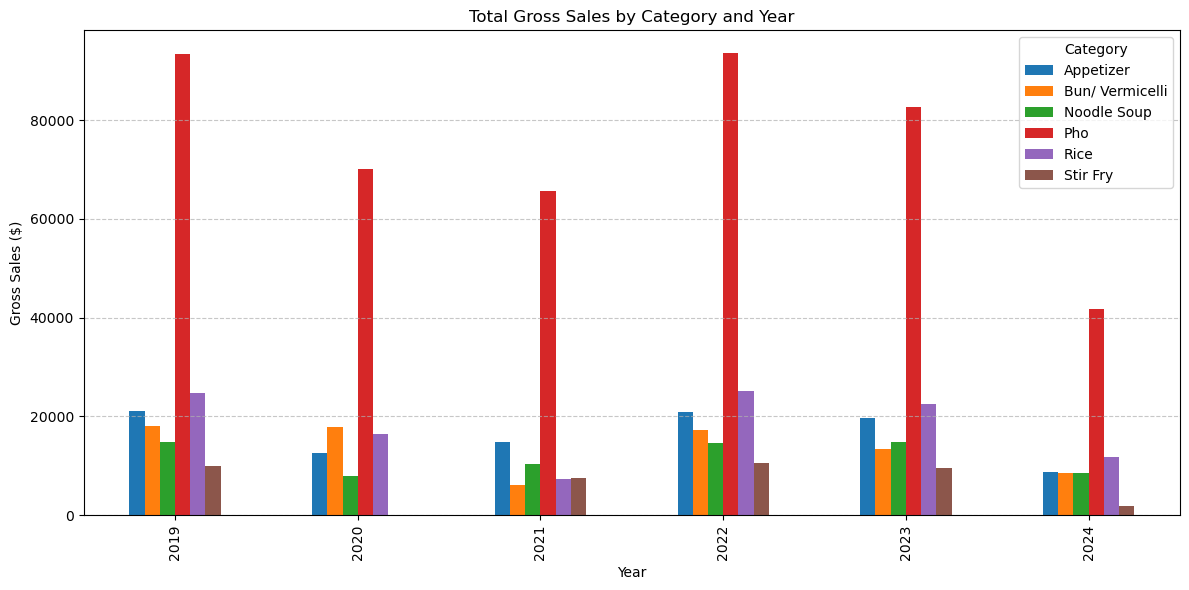

In [11]:
#  rows = year, columns = category, values = total sales
pivot_cat = category_sales.pivot(index='year', columns='Category Name', values='total_sales')

# grouped bar chart
pivot_cat.plot(kind='bar', figsize=(12, 6))
plt.title('Total Gross Sales by Category and Year')
plt.xlabel('Year')
plt.ylabel('Gross Sales ($)')
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The bar chart above shows total gross sales broken down by category across each year from 2019 to 2024. It’s clear that Pho consistently generated the highest sales, which isn’t surprising given that this was a Pho restaurant. Categories like Rice and Appetizers showed steady performance throughout the years, while Stir-Fry and Noodle Soup sales fluctuated more. There is a noticeable dip in overall sales during 2020 and 2021 due to the COVID-19 pandemic, followed by a strong rebound, our best performing year in 2022. This visualization clearly illustrates how each category contributed to annual revenue.

It's also worth noting that 2019 and 2024 were partial years: the restaurant opened in June 2019 and closed in June 2024, which slightly skews those totals. Additionally, these sales figures represent credit card transactions only, and do not include any cash sales.

In [13]:
conn = sqlite3.connect('phospot.db')

query = """
SELECT Name, 
    SUM("Gross Sales") as total_sales,
    SUM(Sold) AS total_units,
    ROUND(SUM("Gross Sales") / SUM(Sold),2) AS avg_price
FROM sales
GROUP BY name
ORDER BY total_sales DESC
LIMIT 10;
"""

top_items = pd.read_sql_query(query,conn)
conn.close()

print(top_items)

                             Name  total_sales  total_units  avg_price
0                P1. Pho Dac Biet    130625.45       9618.0      13.58
1                     P4. Pho Tai     81769.70       6160.0      13.27
2  C1. Com Thit Nuong Trung Op La     54763.40       4291.0      12.76
3                     P14. Pho Ga     53439.30       3965.0      13.48
4                  K3. Bun Bo Hue     49727.55       3401.0      14.62
5  B1. Bun Tom Thit Nuong Cha Gio     37571.70       2611.0      14.39
6             P2. Pho Tai Nam Gau     34680.75       2603.0      13.32
7                    P5. Pho Chin     32117.75       2419.0      13.28
8                     A1. Cha Gio     30118.08       6998.5       4.30
9            P6. Pho Chin Nam Gau     26437.70       1968.0      13.43


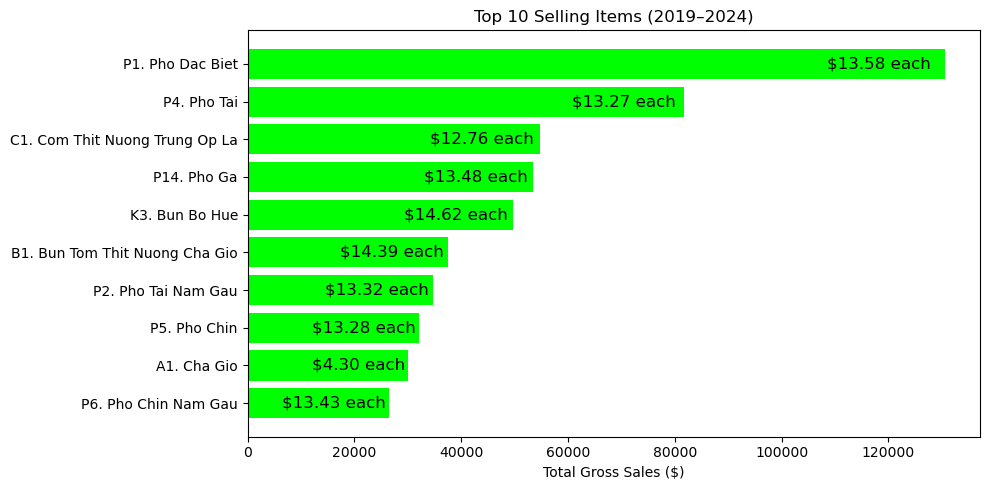

In [14]:
plt.figure(figsize=(10, 5))
bars = plt.barh(top_items['Name'], top_items['total_sales'], color='lime')
plt.xlabel('Total Gross Sales ($)')
plt.title('Top 10 Selling Items (2019–2024)')
plt.gca().invert_yaxis()

for i, bar in enumerate(bars):
    width = bar.get_width()
    avg_price = top_items.loc[i, 'avg_price']
    label = f"${avg_price:.2f} each"

    # position text 
    plt.text(width * 0.98, 
             bar.get_y() + bar.get_height() / 2,
             label,
             va='center',
             ha='right', # right-align 
             color='black',   
             fontsize=12)

plt.tight_layout()
plt.show()

The graph above shows the top 10 selling items at The Pho Spot from 2019-2024, ranked by total gross sales. Each bar represents the total sales revenue for an item, with the average price inside the bar. Unsurprisingly, the restaurant's signature dish, P1. Pho Dac Biet leads in sales by a large margin, followed by other variations of pho and staple Vietnamese dishes. I included the average price of the item to give some context on how pricing influenced the total revenue. While I do not have tangible data on how often we sold out of each item, but from memory K3. Bun Bo Hue would sell out often, especially on the weekends where there was a infux of more Asian patrons. Seeing how it was in the top 5 top selling items, I did increase production to keep up with demand.

In [16]:
#read csv
report_df = pd.read_csv('thephospotreport.csv')

# new database and load table
conn = sqlite3.connect('phospot_report.db')
report_df.to_sql('monthly_report', conn, if_exists='replace', index=False)

#SQL query (total gross sales by year)
query = """
SELECT year, SUM(gross_sales) AS total_sales
FROM monthly_report
GROUP BY year
ORDER BY year;
"""
monthly_report = pd.read_sql_query(query, conn)
conn.close()

print(monthly_report)

   year  total_sales
0  2019    138562.11
1  2020    138902.46
2  2021    216813.23
3  2022    193446.44
4  2023    172799.79
5  2024     86527.45


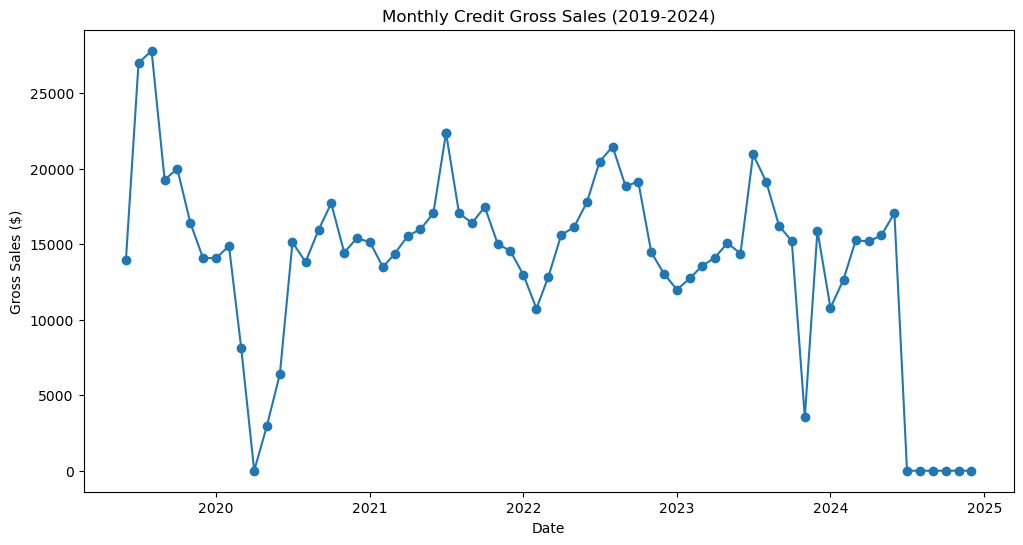

In [17]:
conn = sqlite3.connect('phospot_report.db')

# query: gross sales by year and month
query = """
SELECT year, month, gross_sales
FROM monthly_report
ORDER BY year,
         CASE month
            WHEN 'Jan' THEN 1
            WHEN 'Feb' THEN 2
            WHEN 'Mar' THEN 3
            WHEN 'Apr' THEN 4
            WHEN 'May' THEN 5
            WHEN 'Jun' THEN 6
            WHEN 'Jul' THEN 7
            WHEN 'Aug' THEN 8
            WHEN 'Sep' THEN 9
            WHEN 'Oct' THEN 10
            WHEN 'Nov' THEN 11
            WHEN 'Dec' THEN 12
         END
"""

monthly_sales = pd.read_sql_query(query, conn)
conn.close()

monthly_sales['date'] = pd.to_datetime(monthly_sales['month'] + ' ' + monthly_sales['year'].astype(str), format='%b %Y') #string to date 

monthly_sales = monthly_sales.sort_values('date')

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['date'], monthly_sales['gross_sales'], marker='o')
plt.title('Monthly Credit Gross Sales (2019-2024)')
plt.xlabel('Date')
plt.ylabel('Gross Sales ($)')
plt.show()


The line chart above shows monthly gross sales from June 2019 to June 2024. The sales data was converted into datetime format to ensure accurate chronological sorting and time-based visualization. The graph reveals clear seasonal fluctuations, with a notable dip in sales during 2020 due to the COVID-19 pandemic. In particular, the restaurant was fully closed during April 2020, resulting in zero revenue for that month. Another temporary closure occurred in November 2023, when the restaurant shut down for approximately three weeks due to an emergency trip, which caused a noticeable drop in sales for that month. These anomalies are important to consider when analyzing long-term trends.

The recurring sales peaks observed across the years correspond to the summer months, when the area experiences an influx of tourists and increased local dining activity. As expected, June 2019, our opening month, shows a strong spike in sales driven by the excitement and publicity of a new restaurant launch. This was followed by a decline as concerns over COVID-19 began to spread and rising anti-asian sentiment impacted restaurant traffic and sales.

___
# Recommendations & Insights based on data
* Increase staffing during summer months and decrease during winter
* Increase marketing during spring to build momentum into peak season
* Impact of the 2 closure events
* Covid-19 Impact
* Post-Covid Recovery
* Year over Year growth and decline
* Future planning for sales, loyalty campaigns, and promotions during slow months to increase sales
* Budgeting during the slow months
* Increase food production, especially Bun Bo Hue during peak summer months to capitalize the high demand for a high cost item
  
  

## If I could do this again...
Well first off, I wouldn't. Food cost, rent, payroll, utilities and other expenses are too high in the tourist area of Niagara Falls. Our biggest expense was rent and that was magnified during Covid since we still had to pay the rent with the restaurant being closed. Food cost also played a major role in our decision to close the restaurant, over the years we were open we saw an increase of food and equipment cost sometimes over of 200% (Sriracha shortage of 2022), bottles went from $\$3$ to a high of $\$15$. Beef and chicken prices also doubled from 2019 to 2024, which played a large role in what we decided to keep or remove from the menu. For example, we had Vietnamese Chicken wings for a couple years but then had to remove it due to high cost. A box of wings went from $\$50$ to sometimes $\$200$, probably doesn't help that every other restaurant sells wings here so supply was low but demand was high. Post-Covid era is not a great time to operate a small restaurant and is definitely not worth it.

# Conclusion
This project provided a clear view into The Pho Spot’s credit-based gross sales trends from June 2019 to June 2024. By analyzing point-of-sale data using SQL and Python, several patterns and insights were uncovered that reflect the business operations over time.

Seasonality emerged as a dominant trend, with the summer months particularly July consistently producing the highest sales. In contrast, winter months like January and February often saw lower activity, and months affected by external disruptions (such as April 2020 and November 2023) showed sharp revenue drops due to temporary closures.

The identification of the lowest performing months such as May and June 2020, and January 2024 further highlighted how real-world events like the pandemic significantly influenced performance. On the flip side, high-performing months aligned with predictable seasonal peaks, offering valuable guidance for staffing, marketing, and future planning.

This data during the restaurants operation was used to determine when to run marketing ads, promotions, and deals. It was also used to figure out when to raise prices depending on the cost of goods and the rent increases over time. 

In summary, this project demonstrates the power of simple but consistent sales data to tell a story, one of growth, challenge, adaptation, and recovery. These insights would not only help evaluate past performance but also serve as a strong foundation for any future business planning. 

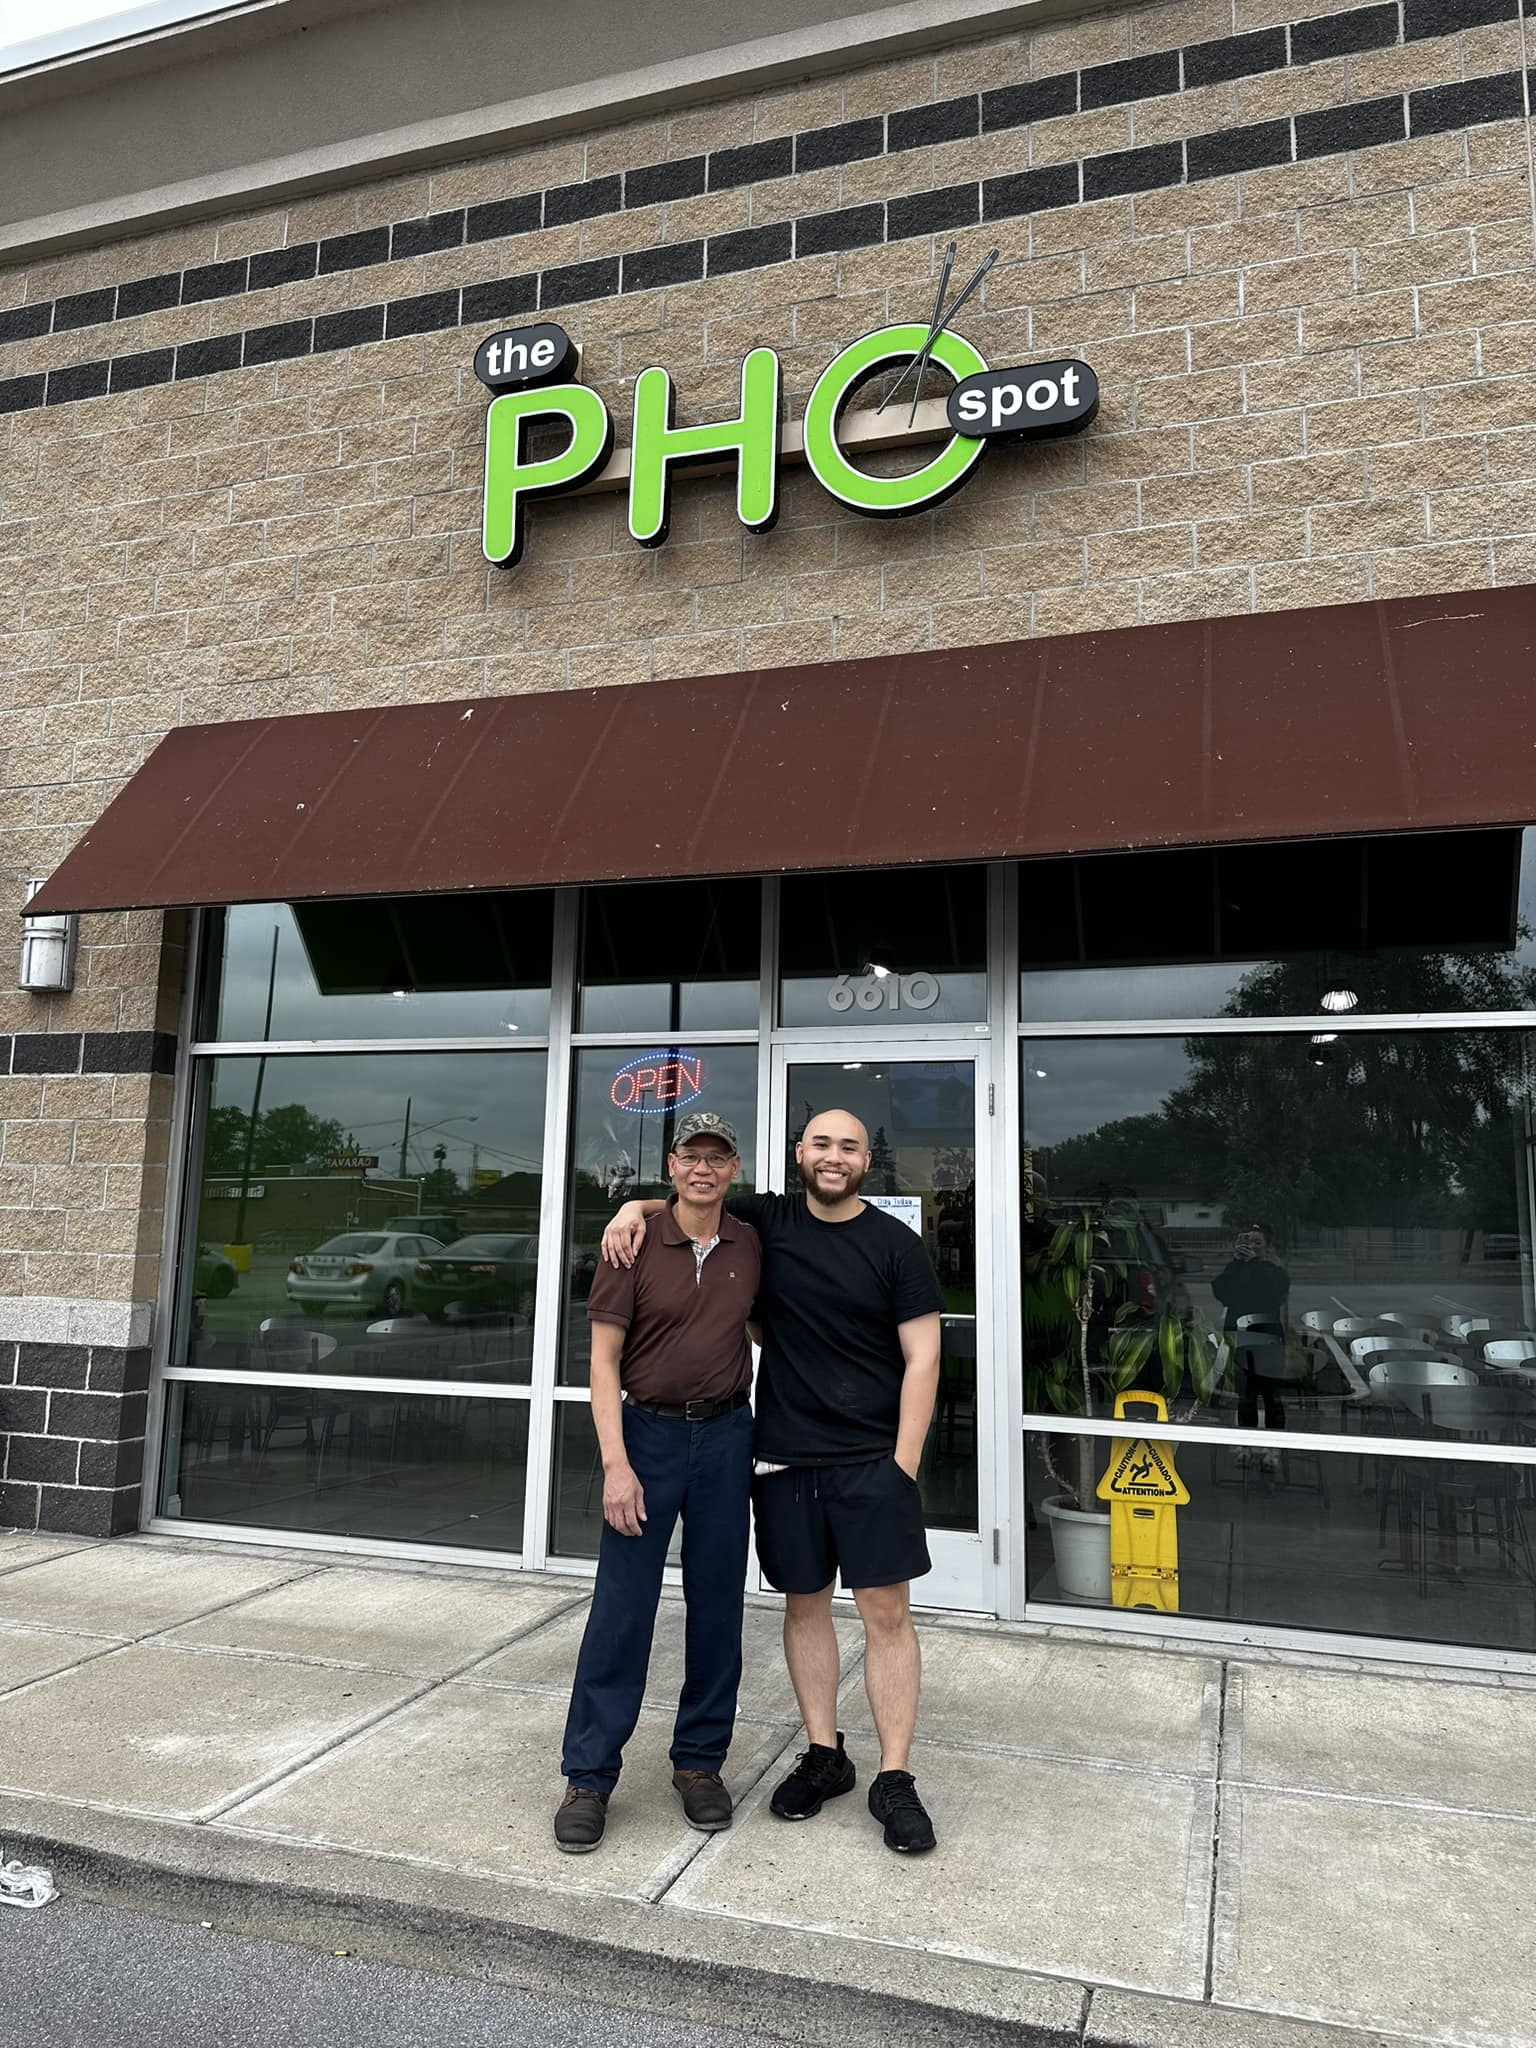

In [5]:
from IPython.display import display, Image

img = Image(filename='TPSphoto.jpg', width=500)
display(img)